# Small energy systems MILP example

__author__ = "Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__license__ = "MIT"
__version__ = "1.0.0"
__maintainer__ = "Rahul Kakodkar"
__email__ = "cacodcar@tamu.edu"
__status__ = "Complete"


A simple problem with three processes

- Solar PV with varying capacity factor
- Wind Farm with varying capacity factor
- Lithium-ion battery storage

and varying demand.

The problem is modeled over two scales

- 0, network scale with 1 time period
- 1, scheduling and demand scales with 4 time periods



**System path**

In [1]:
import sys
sys.path.append('../../src')

**Import modules**

In [2]:
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.scenario import Scenario
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario
import pandas
from energiapy.components.result import Result
from energiapy.model.solve import solve

**Input Data**

Factors are normalized, and can be used to account for:

- variable resource demand (demand_factor)
- intermittent resource availability (capacity factor)
- varying resource purchase cost (cost factor)

In [3]:
demand_factor = pandas.DataFrame(data={'Power': [0.6, 1, 0.8, 0.3]})
capacity_factor_pv = pandas.DataFrame(data={'PV': [0.6, 0.8, 0.9, 0.7]})
capacity_factor_wf = pandas.DataFrame(data={'WF': [0.9, 0.8, 0.5, 0.7]})


**Declare temporal scale**


Consider four seasons in a year.

Network decisions are taken annually (scale level 0)

Scheduling decisions are taken seasonally (scale level 1)


In [4]:
scales = TemporalScale(discretization_list=[1, 4])


**Declare resources**

Resources can be declared with attributes such as maximum consumption (cons_max), resource price (price), maximum allowed inventory (store_max)

As also whether they can be discharged (sell), have to meet demand (demand)

In [5]:
Solar = Resource(name='Solar', cons_max=100, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max=100, basis='MW', label='Wind Power')

# Power = Resource(name='Power', basis='MW', demand=True,
#                  label='Power generated', varying=[VaryingResource.DETERMINISTIC_DEMAND])

Power = Resource(name='Power', basis='MW', label='Power generated')

H2 = Resource(name='H2', basis='kg', label='Hydrogen', block='Resource', demand = True)

H2O = Resource(name='H2O', cons_max=10**10,
               price=0.001, basis='kg', label='Water', block='Resource')

O2 = Resource(name='O2', sell=True, basis='kg', label='Oxygen')


**Declare processes**

Processes consume resources and can be of three type:

- storage, if storage = some_resource 
- single mode, as with the processes defined here wherein a conversions are provided
- multi mode, if a multiconversion dict is provided

In [6]:
prod_max = {0: 20, 1: 60, 2: 100}
prod_min = {0: 0, 1: 20, 2: 60}
rate_max = {0: 20, 1: 30, 2: 20}
mode_ramp = {(0,1): 1, (1,2): 1}


In [7]:
PEM = Process(name='PEM', conversion={0: {Power: -1, H2: 19.474, O2: 763.2, H2O: -175.266}, 1: {Power: -1, H2: 19.474*1.1, O2: 763.2*1.1, H2O: -175.266*1.1},
                                      2: {Power: -1, H2: 19.474*1.15, O2: 763.2*1.15, H2O: -175.266*1.15}}, rate_max=rate_max, mode_ramp = mode_ramp, capex=784000, fopex=17000, 
              vopex=20, prod_max=prod_max, prod_min=prod_min, label='PEM electrolyzer', basis='MW')

LiI = Process(name='LiI', storage=Power, capex=1302182, fopex=41432, prod_min=20,
              vopex=2000,  prod_max=100, label='Lithium-ion battery', basis='MW', storage_loss = 0.04)

WF = Process(name='WF', conversion={Wind: -1, Power: 1}, capex=990637, fopex=3354, vopex=4953,
             prod_max=100, label='Wind mill array', varying=[VaryingProcess.DETERMINISTIC_CAPACITY], basis='MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=567000, fopex=872046, vopex=90000,
             prod_max=100, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Solar PV', basis='MW')


In [8]:
LiI.resource_req

{'LiI_Power_stored', 'Power'}

In [9]:
PEM.varying

[<VaryingProcess.CERTAIN_EXPENDITURE: 6>, <VaryingProcess.MULTIMODE: 7>]

**Declare location**


Locations are essentially a set of processes, the required resources are collected implicitly.

Location-wise capacity, demand, and cost factors can be provided. 

The scales of the capacity and demand data need to be provided as well.

In [10]:
place = Location(name='place', processes={LiI, PV, WF, PEM}, demand_factor={Power: demand_factor}, capacity_factor={PV: capacity_factor_pv, WF: capacity_factor_wf},
                 capacity_scale_level=1, demand_scale_level=1, scales=scales, label='some place')


*plot varying factors*

Plotting functions in energiapy.plot can be used to plot the factors

In [11]:
# plot.capacity_factor(location= place, process= PV, fig_size= (9,5), color= 'orange')
# plot.capacity_factor(location= place, process= WF, fig_size= (9,5), color= 'blue')
# plot.demand_factor(location= place, resource= Power, fig_size= (9,5), color= 'red')


**Declare scenario**

The combination of parameter data, locations, and transportation options generates a scenario. 

Scenarios are data sets that can be fed to models for analysis. 

In this case we are generating a scenario for the location houston. The scales need to be consistent.

The demand, network, scheduling, and expenditure scales need to be provided. They all default to 0.

In [12]:
case = Scenario(name='case', network=place, demand={place: {
                Power: 30, H2: 1}}, network_scale_level=0, demand_scale_level=1, scheduling_scale_level=1, capacity_scale_level = 1, scales=scales, label='small scenario')


In [13]:
case.mode_dict

{'PEM': [0, 1, 2], 'LiI_discharge': [0], 'LiI': [0], 'PV': [0], 'WF': [0]}

**Formulate MILP**

Models can be formulated using different constraints and objectives.

milp is a pyomo instance, additional constraints can be provided in a bespoke manner

In [14]:
len(case.mode_dict['WF'])

1

In [15]:
milp = formulate(scenario=case,  constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                                              Constraints.RESOURCE_BALANCE, Constraints.TRANSPORT, Constraints.NETWORK, Constraints.MODE, Constraints.DEMAND}, objective=Objective.COST)


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint production mode facility
constraint min production mode facility
constraint production mode binary
constraint production rate1
constraint production rate2
constraint production mode switch
constraint demand
objective cost


In [16]:
milp.write('model.lp')


('model.lp', 2495671643840)

**Solve**

In [17]:
case.prod_max

{'place': {'PEM': {0: 20, 1: 60, 2: 100},
  'LiI_discharge': {0: 100},
  'LiI': {0: 100},
  'PV': {0: 100},
  'WF': {0: 100}}}

To solve the model, the solve requires a scenario and a modeling instance to be provided. 

Also a solver needs to be chosen.

In [18]:
results = solve(scenario=case, instance=milp, solver='gurobi', name=f"MILP")


Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 273 rows, 265 columns and 705 nonzeros
Model fingerprint: 0x781b0306
Variable types: 180 continuous, 85 integer (85 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 207 rows and 217 columns
Presolve time: 0.01s
Presolved: 66 rows, 48 columns, 220 nonzeros
Variable types: 27 continuous, 21 integer (9 binary)
Found heuristic solution: objective 2.694943e+07

Root relaxation: objective 7.678499e+04, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |

In [31]:
milp.X_P_mm.pprint()

X_P_mm : Production mode transition binaries
    Size=52, Index=X_P_mm_index
    Key                                    : Lower : Value : Upper : Fixed : Stale : Domain
              ('place', 'LiI', 0, 0, 0, 0) :     0 :  None :     1 : False :  True : Binary
              ('place', 'LiI', 0, 0, 0, 1) :     0 :  None :     1 : False :  True : Binary
              ('place', 'LiI', 0, 0, 0, 2) :     0 :  None :     1 : False :  True : Binary
              ('place', 'LiI', 0, 0, 0, 3) :     0 :  None :     1 : False :  True : Binary
    ('place', 'LiI_discharge', 0, 0, 0, 0) :     0 :  None :     1 : False :  True : Binary
    ('place', 'LiI_discharge', 0, 0, 0, 1) :     0 :  None :     1 : False :  True : Binary
    ('place', 'LiI_discharge', 0, 0, 0, 2) :     0 :  None :     1 : False :  True : Binary
    ('place', 'LiI_discharge', 0, 0, 0, 3) :     0 :  None :     1 : False :  True : Binary
              ('place', 'PEM', 0, 0, 0, 0) :     0 :  None :     1 : False :  True : Binary
   

In [20]:
milp.constraint_production_rate2.pprint()

constraint_production_rate2 : production mode rate 1
    Size=12, Index=constraint_production_rate2_index, Active=True
    Key                       : Lower : Body                                                                                                          : Upper : Active
    ('place', 'PEM', 0, 0, 0) :  -Inf : P_m[place,PEM,0,0,0] - P_m[place,PEM,0,0,3] - (20 + 30*(2 - X_P_m[place,PEM,0,0,0] - X_P_m[place,PEM,0,0,3])) :   0.0 :   True
    ('place', 'PEM', 0, 0, 1) :  -Inf : P_m[place,PEM,0,0,1] - P_m[place,PEM,0,0,0] - (20 + 30*(2 - X_P_m[place,PEM,0,0,1] - X_P_m[place,PEM,0,0,0])) :   0.0 :   True
    ('place', 'PEM', 0, 0, 2) :  -Inf : P_m[place,PEM,0,0,2] - P_m[place,PEM,0,0,1] - (20 + 30*(2 - X_P_m[place,PEM,0,0,2] - X_P_m[place,PEM,0,0,1])) :   0.0 :   True
    ('place', 'PEM', 0, 0, 3) :  -Inf : P_m[place,PEM,0,0,3] - P_m[place,PEM,0,0,2] - (20 + 30*(2 - X_P_m[place,PEM,0,0,3] - X_P_m[place,PEM,0,0,2])) :   0.0 :   True
    ('place', 'PEM', 1, 0, 0) :  -Inf : P_m[pl

**Results**

In [21]:
milp.constraint_production_facility.pprint()

constraint_production_facility : production facility sizing and location
    Size=5, Index=constraint_production_facility_index, Active=True
    Key                           : Lower : Body                                                          : Upper : Active
              ('place', 'LiI', 0) :  -Inf :                     Cap_P[place,LiI,0] - 100*X_P[place,LiI,0] :   0.0 :   True
    ('place', 'LiI_discharge', 0) :  -Inf : Cap_P[place,LiI_discharge,0] - 100*X_P[place,LiI_discharge,0] :   0.0 :   True
              ('place', 'PEM', 0) :  -Inf :                     Cap_P[place,PEM,0] - 100*X_P[place,PEM,0] :   0.0 :   True
               ('place', 'PV', 0) :  -Inf :                       Cap_P[place,PV,0] - 100*X_P[place,PV,0] :   0.0 :   True
               ('place', 'WF', 0) :  -Inf :                       Cap_P[place,WF,0] - 100*X_P[place,WF,0] :   0.0 :   True


In [22]:
milp.constraint_min_production_mode_facility.pprint()

constraint_min_production_mode_facility : production facility sizing and location
    Size=28, Index=constraint_min_production_mode_facility_index, Active=True
    Key                                 : Lower : Body                                                                     : Upper : Active
              ('place', 'LiI', 0, 0, 0) :  -Inf :                     20*X_P_m[place,LiI,0,0,0] - Cap_P_m[place,LiI,0,0,0] :   0.0 :   True
              ('place', 'LiI', 0, 0, 1) :  -Inf :                     20*X_P_m[place,LiI,0,0,1] - Cap_P_m[place,LiI,0,0,1] :   0.0 :   True
              ('place', 'LiI', 0, 0, 2) :  -Inf :                     20*X_P_m[place,LiI,0,0,2] - Cap_P_m[place,LiI,0,0,2] :   0.0 :   True
              ('place', 'LiI', 0, 0, 3) :  -Inf :                     20*X_P_m[place,LiI,0,0,3] - Cap_P_m[place,LiI,0,0,3] :   0.0 :   True
    ('place', 'LiI_discharge', 0, 0, 0) :  -Inf : 20*X_P_m[place,LiI_discharge,0,0,0] - Cap_P_m[place,LiI_discharge,0,0,0] :   0.0 :   True


In [23]:
milp.P_m.pprint()

P_m : Production modes
    Size=28, Index=P_m_index
    Key                                 : Lower : Value                : Upper : Fixed : Stale : Domain
              ('place', 'LiI', 0, 0, 0) :     0 :                  0.0 :  None : False : False : NonNegativeReals
              ('place', 'LiI', 0, 0, 1) :     0 :                  0.0 :  None : False : False : NonNegativeReals
              ('place', 'LiI', 0, 0, 2) :     0 :                  0.0 :  None : False : False : NonNegativeReals
              ('place', 'LiI', 0, 0, 3) :     0 :                  0.0 :  None : False : False : NonNegativeReals
    ('place', 'LiI_discharge', 0, 0, 0) :     0 :                  0.0 :  None : False : False : NonNegativeReals
    ('place', 'LiI_discharge', 0, 0, 1) :     0 :                  0.0 :  None : False : False : NonNegativeReals
    ('place', 'LiI_discharge', 0, 0, 2) :     0 :                  0.0 :  None : False : False : NonNegativeReals
    ('place', 'LiI_discharge', 0, 0, 3) :     

In [24]:
case.prod_min

{'place': {'PEM': {0: 0, 1: 20, 2: 60},
  'LiI_discharge': {0: 20},
  'LiI': {0: 20},
  'PV': {0: 0},
  'WF': {0: 0}}}

In [25]:
max(case.prod_min['place']['PV'].values())


0

In [26]:
max(case.rate_max_dict['PEM'].values())

30

In [27]:
# milp.constraint_production_mode_facility_capacity.pprint()


Models can be summarized as shown below:

In [28]:
results.model_summary()


SUMMARY:
            number of constraints: 273
            number of variables: 265
            number of binary variables: 85
            number of integer variables: 85
            number of continuous variables: 95


*Plot results*

Some handy plotting functions such as schedule can plot the production, consumption, sales, inventory schedules

In [29]:
case.resource_set

{H2, H2O, LiI_Power_stored, O2, Power, Solar, Wind}

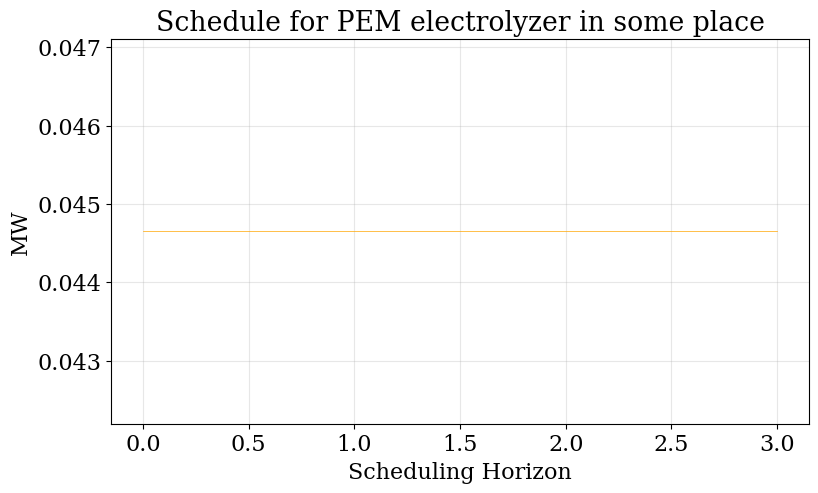

In [32]:
plot_results.schedule(results=results, y_axis='P', component='PEM',
              location='place', fig_size=(9, 5), color='orange')

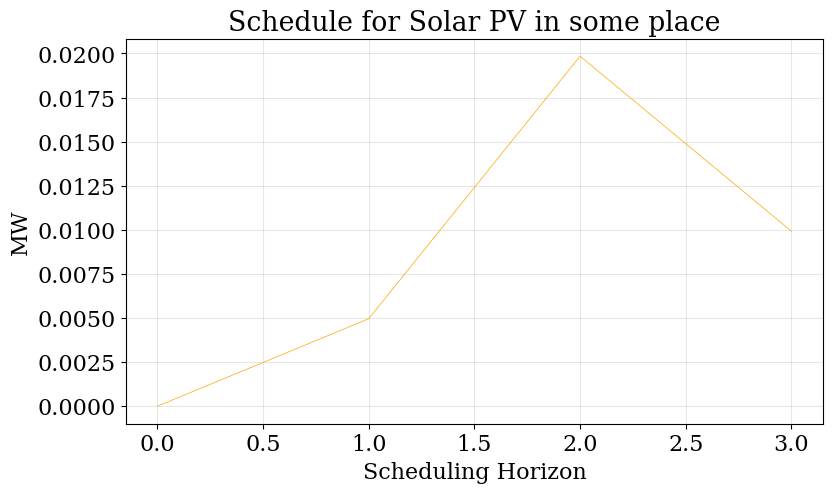

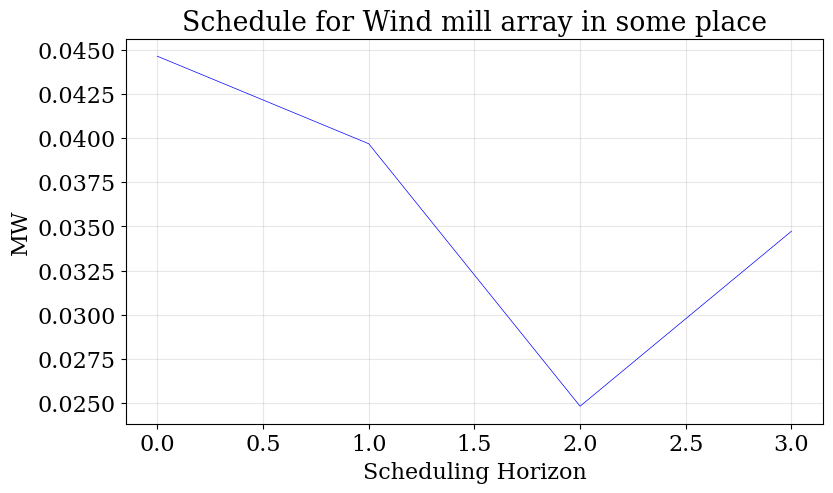

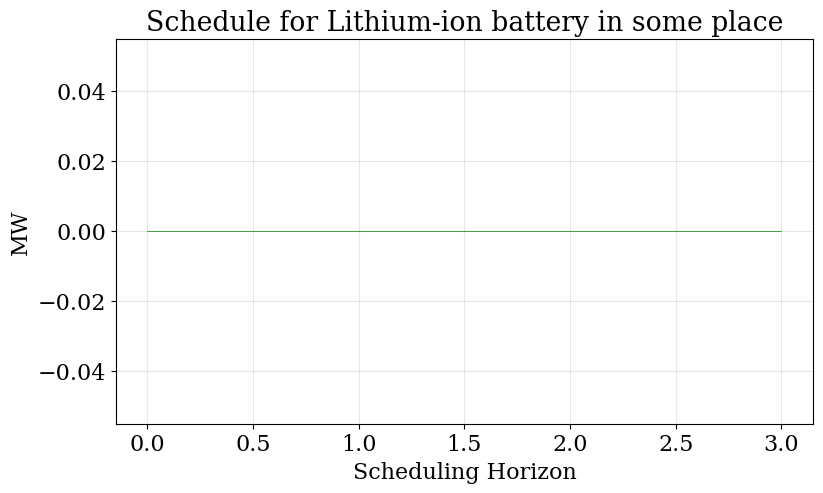

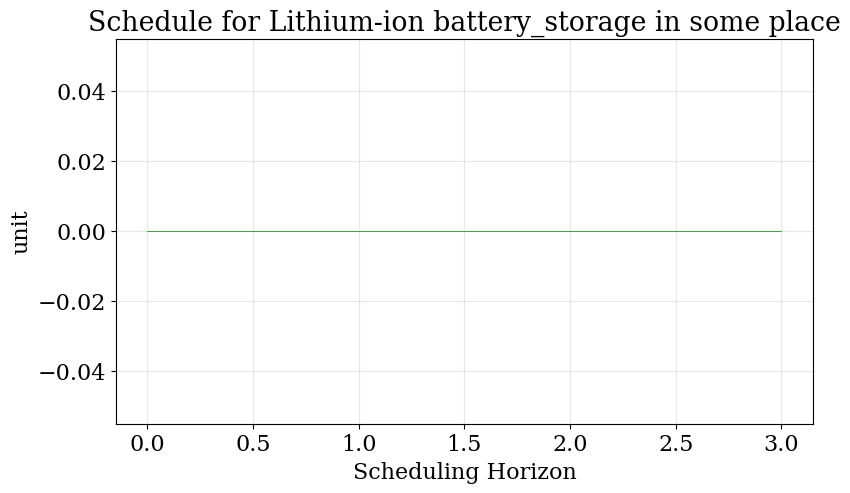

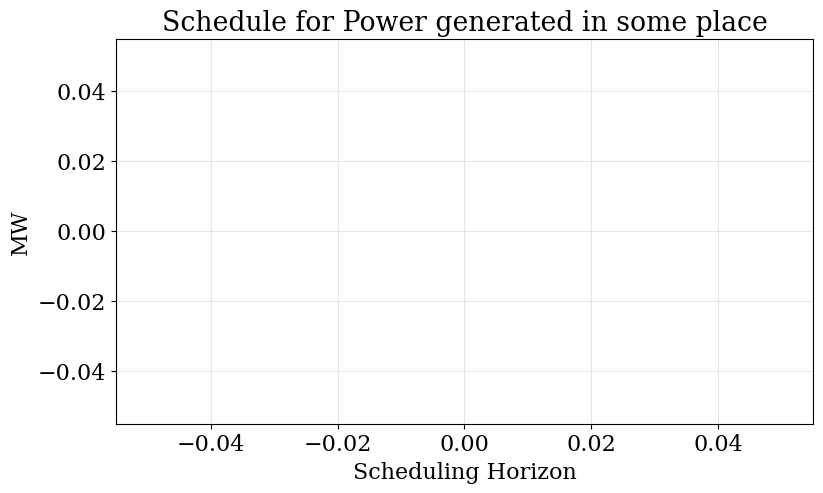

In [30]:
plot_results.schedule(results=results, y_axis='P', component='PV',
              location='place', fig_size=(9, 5), color='orange')
plot_results.schedule(results=results, y_axis='P', component='WF',
              location='place', fig_size=(9, 5), color='blue')
plot_results.schedule(results=results, y_axis='P', component='LiI',
              location='place', fig_size=(9, 5), color='green')
plot_results.schedule(results=results, y_axis='P', component='LiI_discharge',
              location='place', fig_size=(9, 5), color='green')
plot_results.schedule(results=results, y_axis='Inv', component='Power',
              location='place', fig_size=(9, 5), color='green')


All inputs are stored in results.component

All outputs are stored in results.output

Values can be accessed as shown below